# Starter Notebook

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

In [ ]:
!pip install datasets

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel, prepare_model_for_kbit_training
from datasets import load_dataset, Dataset, ClassLabel
import pickle
import numpy as np

In [ ]:
# This method plots a graph of Accururacy vs Tokens length
def plot_accuracy_to_length(predictions, labels, input_lengths):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict
    correct_by_len = defaultdict(int)
    total_by_len = defaultdict(int)
    # Calculate accuracy mapped by length
    for pred, label, length in zip(predictions, labels, input_lengths):
        total_by_len[length] += 1
        if pred == label:
            correct_by_len[length] += 1
    # Plot the accuracy
    accuracy_by_len = {length: correct_by_len[length] / total_by_len[length] for length in total_by_len}
    sorted_lengths = sorted(accuracy_by_len.keys())
    accuracies = [accuracy_by_len[l] for l in sorted_lengths]
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_lengths, accuracies, marker='o', linestyle='-', color='royalblue')
    plt.title("Accuracy vs. Input Length")
    plt.xlabel("Input Length")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Load Tokenizer and Preprocess Data

In [ ]:
# Cleaning the data
import re
# Removes
def remove_jargon(txt):
  txt = re.sub(r"\$\d+(\.\d+)?[Mm]?", "<MONEY>", txt) # Converts dollars into a token. Eg $5M -> <MONEY>
  txt = re.sub(r"https?://\S+|www\.\S+", "<URL>", txt) # Converts url into a token. Eg http://google.com -> <URL>
  txt = re.sub(r"\b[A-Z]{2,}\b", lambda m: m.group(0).lower(), txt)
  return txt

def clean_text(data):
    cleaned_text = remove_jargon(data["text"])
    return {"text": cleaned_text}

In [ ]:
def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True, max_length=280) # Truncates the text to 280 tokens
    return tokenized
def preprocess_wo_ml(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
dataset = load_dataset('ag_news', split='train')
tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [ ]:
# Split the original training set
print(len(tokenized_dataset))
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train'].shuffle(seed=42)
eval_dataset = split_datasets['test'].shuffle(seed=42)
len(train_dataset)/32

120000


3730.0

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# Benchmark Config Test accuracy 85.375%
rank_pattern1 = {
    '.*query': 2,
    '.*key': 2,
    '.*value': 2,
    '.*attention.output.dense': 4,
    '.*output.dense':2,
    '.*intermediate.dense':2
}
peft_config1 = LoraConfig(
    r=4,
    # lora_alpha = 8,
    alpha_pattern={"query": 4, "key": 4,"value":4,"attention.output.dense":8,
                   "output.dense":4,
                   'intermediate.dense':4
                   },
    lora_dropout=0.1,
    bias="none",
    target_modules=[
        "query", "key", "value",
        "attention.output.dense",
        'output.dense',
        'intermediate.dense'
    ],
    modules_to_save = ['attention.output.LayerNorm'],
    rank_pattern=rank_pattern1,
    task_type="SEQ_CLS",
)

# Config 2, Test Accuracy 85%
layers = [1,3,5,7,9,10,11]
modules_to_save2 = []
target_modules2 = []
for i in layers:
    target_modules2.append(f"roberta.encoder.layer.{i}.attention.self.query")
    target_modules2.append(f"roberta.encoder.layer.{i}.attention.self.key")
    target_modules2.append(f"roberta.encoder.layer.{i}.attention.self.value")
    target_modules2.append(f"roberta.encoder.layer.{i}.attention.output.dense")
    target_modules2.append(f"roberta.encoder.layer.{i}.intermediate.dense")
    target_modules2.append(f"roberta.encoder.layer.{i}.output.dense")
    modules_to_save2.append(f"roberta.encoder.layer.{i}.attention.output.LayerNorm")
    if i in [5,7,9,10,11]:
        modules_to_save2.append(f"roberta.encoder.layer.{i}.output.LayerNorm")

peft_config2 = LoraConfig(
    r=4,
    lora_alpha = 8,
    lora_dropout=0.1,
    bias="none",
    target_modules=target_modules2,
    modules_to_save = modules_to_save2,
    task_type="SEQ_CLS",
)

In [ ]:
peft_model = get_peft_model(model, peft_config1)

In [ ]:
print("Trainable parameters:")
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.output.dense.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.output.dense.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.output.LayerNorm.modules_to_save.default.weight
base_model.model.roberta.encoder.layer.0.attention.output.LayerNorm.modules_to_save.default.bias
base_model.model.roberta.encoder.layer.0.output.dense.lora_A.default.weight
base_model.model.roberta.encoder.l

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807


## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    incorrect_indices = np.where(preds != labels)[0]
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [ ]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    logging_steps=1000,
    warmup_ratio=0.1,
    eval_steps = 1000,
    weight_decay=0.01,
    learning_rate=5e-4,
    lr_scheduler_type="cosine",
    num_train_epochs=4,
    fp16=True,
    dataloader_num_workers=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    optim="adamw_torch"
)
def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)
result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
1000,0.459500,0.243590,0.918750
2000,0.229600,0.218675,0.921875
3000,0.211100,0.206774,0.939063
4000,0.191900,0.185485,0.939063
5000,0.177100,0.200125,0.932813
6000,0.169800,0.192626,0.937500
7000,0.167800,0.192460,0.929688
8000,0.150400,0.195491,0.932813
9000,0.141100,0.170484,0.942187
10000,0.138200,0.166952,0.939063


/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9fb1f0d0-cca1-4b74-bed1-700804e34543)') - silently ignoring the lookup for the file config.json in roberta-base.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in roberta-base - will assume that the vocabulary was not modified.
  warnings.warn(


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [ ]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlingand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None, testCheck=False):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    all_predictions1 = []
    if labelled:
        metric = evaluate.load('accuracy')
    all_labels = []
    all_input_lengths = []
    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())
        if not testCheck:
            all_predictions1.extend([id2label[p.item()] for p in predictions.cpu()])
            all_labels.extend([id2label[l.item()] for l in batch['labels'].cpu()])
            all_input_lengths.extend([len(input) for input in batch['input_ids']])
        if not testCheck:
            for label, input, pred in zip(batch['labels'],batch['input_ids'],predictions):
                if pred.item() != label.item():
                    with open('newlog2.txt', 'a') as file:
                        # input: {tokenizer.decode(input, skip_special_tokens=True)}
                        file.write(f"Prediction: {id2label[pred.item()]}, Label: {id2label[label.item()]}, InputLen: {len(input)}\n")
        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )
    if not testCheck:
        plot_accuracy_to_length(all_predictions1, all_labels, all_input_lengths)
    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

100%|██████████| 80/80 [00:04<00:00, 18.11it/s]


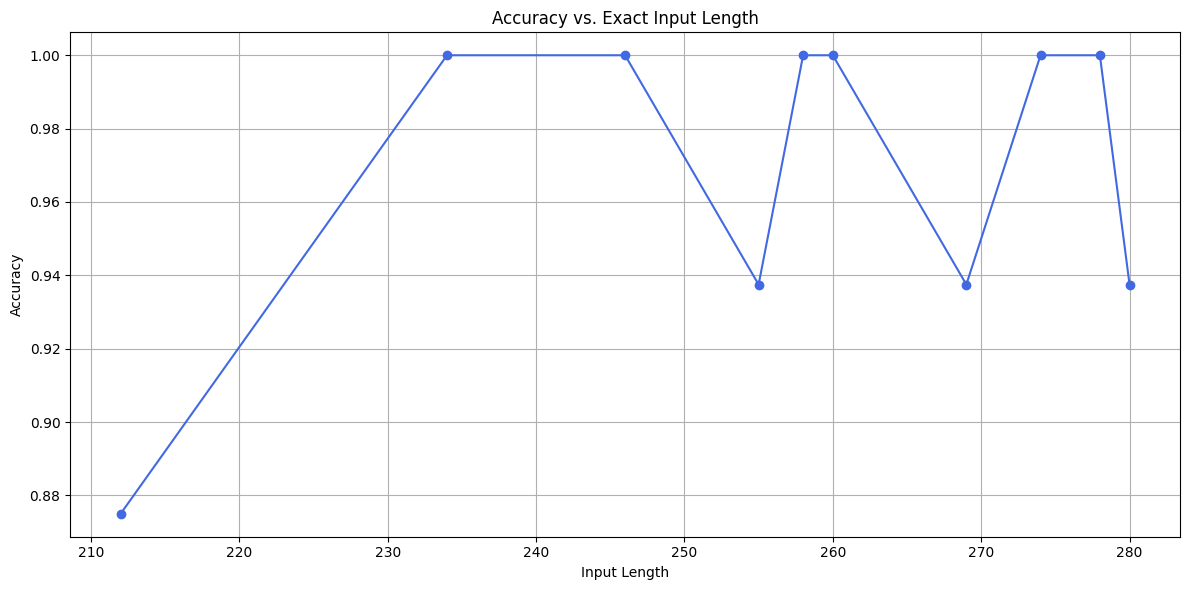

Evaluation Metric: {'accuracy': 0.94375}


In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
# loaded_model = PeftModel.from_pretrained(model, 'results/checkpoint-3500')

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator, True)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:45<00:00, 21.81it/s]

Inference complete. Predictions saved to inference_output.csv
